# RQ1 — Evaluating Household Tariffs on ResStock MA Sample

**Research Question 1 (RQ1)**  
How do different retail electricity tariff structures (e.g., flat rate, time-of-use, real-time pricing proxy) affect:
- total annual bills for households, and  
- the distribution of costs across households with different characteristics  
in a realistic sample of Massachusetts residential load profiles?

This notebook:
1. Loads a sample of individual-building 15-minute load profiles from the NREL ResStock AMY2018 dataset (MA, upgrade 0 / baseline).  
2. Loads the corresponding building-level metadata and dictionary files.  
3. Runs sanity checks to confirm we have the right data to evaluate RQ1 before scaling to the full dataset.  

In [1]:
from pathlib import Path
import sys

import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (10, 4)

# Make sure we can import loadOEDIData.py from aidms-final-project
project_dir = Path("aidms-final-project").resolve()
if str(project_dir) not in sys.path:
    sys.path.append(str(project_dir))

from loadOEDIData import load_all, load_timeseries_for_buildings

print("Python executable:", sys.executable)
print("Project dir:", project_dir)


Python executable: c:\Users\Manny\AppData\Local\Programs\Python\Python312\python.exe
Project dir: C:\Users\Manny\Desktop\aidms\aidms-final-project\aidms-final-project


## Data sources and formats

We use a local mirror of the NREL **ResStock AMY2018** dataset:

- **Source:** `oedi-data-lake/nrel-pds-building-stock/end-use-load-profiles-for-us-building-stock/2025/resstock_amy2018_release_1`
- **Local root:** `../OEDIDataset/`

Within `OEDIDataset`:

- `*.parquet` — Individual-building 15-minute timeseries for **baseline** (`upgrade_id = 0`) buildings in Massachusetts.  
  - Columns include `bldg_id`, `timestamp`, `in.sqft`, and multiple `out.electricity.*.energy_consumption..kwh` end-use columns.
- `metadata/upgrade0.parquet` — Building-level characteristics and annual results for all baseline buildings (nationwide).
- `dictionaries/`
  - `data_dictionary.tsv` — Descriptions of all `in.*` and `out.*` fields.
  - `enumeration_dictionary.tsv` — Expansion of categorical codes (e.g., region, tenure).
- `timeseries_aggregates/by_state/state=MA/*.csv` — MA-level aggregate load profiles by building type (used for sanity checks).

This notebook **only** touches whichever building timeseries files are present in `OEDIDataset` (e.g., the initial 1000 MA buildings, or more if added later).


In [2]:
# Load all preprocessed pieces via helper module
all_data = load_all()

meta = all_data["metadata"]                      # building-level metadata (nationwide)
data_dict = all_data["data_dictionary"]          # column descriptions
enum_dict = all_data["enumeration_dictionary"]   # enumeration descriptions
ts_index = all_data["timeseries_index"]          # index of local building timeseries files
agg_ma = all_data["state_aggregates"]            # MA state-level aggregates (if present)

print("Metadata shape:", None if meta is None else meta.shape)
print("Timeseries files (local):", len(ts_index))
print("Data dictionary:", None if data_dict is None else data_dict.shape)
print("Enumeration dictionary:", None if enum_dict is None else enum_dict.shape)
print("MA aggregates:", None if agg_ma is None else agg_ma.shape)

# Restrict metadata to the buildings we actually downloaded timeseries for
if meta is not None:
    bldg_ids = ts_index["building_id"].unique()
    meta_sample = meta[meta["bldg_id"].isin(bldg_ids)].copy()
    print("Metadata rows for local timeseries buildings:", len(meta_sample))
else:
    meta_sample = None


=== Loading OEDI dataset pieces ===
[load_metadata] Reading upgrade0.parquet ...
[load_metadata] Combined metadata shape: (549971, 771)
[load_dictionaries] Reading data_dictionary.tsv ...
[load_dictionaries] data_dictionary shape: (841, 5)
[load_dictionaries] Reading enumeration_dictionary.tsv ...
[load_dictionaries] UTF-8 decode failed, retrying with latin-1 ...
[load_dictionaries] enumeration_dictionary shape: (58457, 3)
[build_timeseries_index] Found timeseries files: 1000
[load_state_aggregates] Reading up00-ma-mobile_home.csv ...
[load_state_aggregates] Reading up00-ma-multi-family_with_2_-_4_units.csv ...
[load_state_aggregates] Reading up00-ma-multi-family_with_5plus_units.csv ...
[load_state_aggregates] Reading up00-ma-single-family_attached.csv ...
[load_state_aggregates] Reading up00-ma-single-family_detached.csv ...
[load_state_aggregates] Combined aggregate shape: (175200, 97)
=== Done loading OEDI dataset pieces ===
Metadata shape: (549971, 771)
Timeseries files (local): 1

## Sanity checks before using this sample for RQ1

Before designing tariffs and computing bills, we want to confirm:

1. **Timeseries coverage**  
   - Each building has full-year 15-minute data (no large gaps).  
   - We can compute total kWh per 15-min step by summing end-use columns.

2. **Metadata alignment**  
   - Every building with timeseries has a matching metadata row.  
   - We have key fairness-relevant attributes: income proxy, building type, tenure, region/county.

3. **Reasonable consumption levels**  
   - Annual kWh per building is in a plausible range.  
   - Aggregate behavior roughly matches MA state aggregates.

We’ll do lightweight checks using a subset of buildings (e.g., up to 50), but code is written to adapt to any number of local parquet files.


In [3]:
# Choose how many buildings to use for sanity checks
N_SAMPLE_BUILDINGS = 50

n_available = len(ts_index)
n_use = min(N_SAMPLE_BUILDINGS, n_available)
print(f"Using {n_use} / {n_available} buildings for timeseries sanity checks")

ts_sample = load_timeseries_for_buildings(ts_index, n_files=n_use)
print("ts_sample shape:", ts_sample.shape)

# Identify electricity end-use columns
elec_cols = [
    c for c in ts_sample.columns
    if c.startswith("out.electricity.")
    and c.endswith(".energy_consumption..kwh")
]
print("Number of electricity end-use columns:", len(elec_cols))

# Total whole-house electricity kWh per 15-min interval
ts_sample["kwh_total"] = ts_sample[elec_cols].sum(axis=1)

ts_sample[["bldg_id", "timestamp", "kwh_total"]].head()


Using 50 / 1000 buildings for timeseries sanity checks
[load_timeseries_for_buildings] Reading 100043-0.parquet ...
[load_timeseries_for_buildings] Reading 10010-0.parquet ...
[load_timeseries_for_buildings] Reading 100158-0.parquet ...
[load_timeseries_for_buildings] Reading 100185-0.parquet ...
[load_timeseries_for_buildings] Reading 100194-0.parquet ...
[load_timeseries_for_buildings] Reading 100204-0.parquet ...
[load_timeseries_for_buildings] Reading 100208-0.parquet ...
[load_timeseries_for_buildings] Reading 100325-0.parquet ...
[load_timeseries_for_buildings] Reading 100339-0.parquet ...
[load_timeseries_for_buildings] Reading 100440-0.parquet ...
[load_timeseries_for_buildings] Reading 100500-0.parquet ...
[load_timeseries_for_buildings] Reading 100512-0.parquet ...
[load_timeseries_for_buildings] Reading 100538-0.parquet ...
[load_timeseries_for_buildings] Reading 100602-0.parquet ...
[load_timeseries_for_buildings] Reading 100649-0.parquet ...
[load_timeseries_for_buildings]

,bldg_id,timestamp,kwh_total
0,100043,2018-01-01 00:15:00,0.93137
1,100043,2018-01-01 00:30:00,0.94122
2,100043,2018-01-01 00:45:00,0.92111
3,100043,2018-01-01 01:00:00,0.93854
4,100043,2018-01-01 01:15:00,0.91068


Annual kWh from timeseries (sample):


,bldg_id,annual_kwh_ts
count,50.000000,50.000000
mean,93876.140000,26298.279297
std,24966.516152,21581.371094
min,10010.000000,1079.192017
25%,100455.000000,13500.969727
50%,101244.500000,21114.399414
75%,101676.000000,34025.972168
max,102103.000000,121652.367188


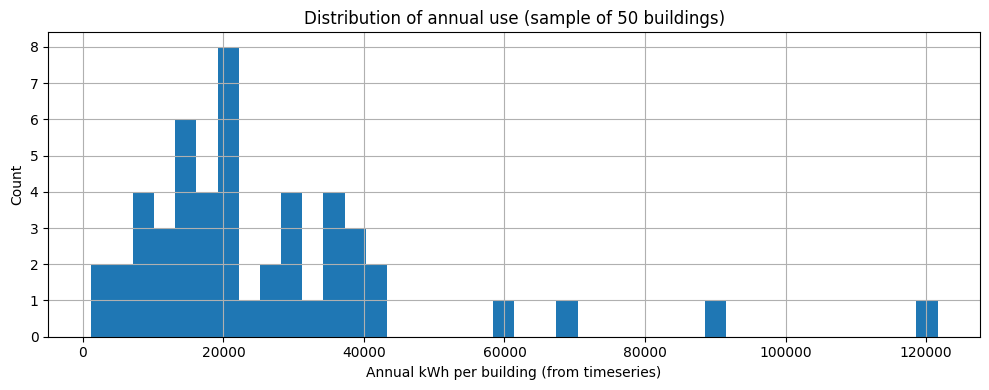

In [ ]:
# Annual kWh per building from timeseries
annual_kwh_ts = (
    ts_sample.groupby("bldg_id")["kwh_total"]
    .sum()
    .reset_index(name="annual_kwh_ts")
)

print("Annual kWh from timeseries (sample):")
display(annual_kwh_ts.describe())

# Histogram
plt.figure()
annual_kwh_ts["annual_kwh_ts"].hist(bins=40)
plt.xlabel("Annual kWh per building (from timeseries)")
plt.ylabel("Count")
plt.title(f"Distribution of annual use (sample of {n_use} buildings)")
plt.tight_layout()
plt.show()

In [5]:
if meta_sample is not None:
    meta_for_sample = meta_sample.merge(
        annual_kwh_ts, left_on="bldg_id", right_on="bldg_id", how="inner"
    )
    print("Joined metadata + annual kWh shape:", meta_for_sample.shape)

    # Some useful columns (only keep those that exist)
    candidate_cols = [
        "bldg_id",
        "in.county_name",
        "in.ahs_region",
        "in.representative_income",
        "in.building_type_recs",
        "in.tenure",
    ]
    existing_cols = [c for c in candidate_cols if c in meta_for_sample.columns]
    display(meta_for_sample[existing_cols].head())
else:
    meta_for_sample = None
    print("No metadata loaded; cannot join.")

Joined metadata + annual kWh shape: (50, 772)


,bldg_id,in.county_name,in.ahs_region,in.representative_income,in.tenure
0,10010,Essex County,"CBSA Boston-Cambridge-Newton, MA-NH",190819.0,Owner
1,10069,Middlesex County,"CBSA Boston-Cambridge-Newton, MA-NH",132034.0,Owner
2,10083,Hampshire County,Non-CBSA New England,73823.0,Owner
3,10180,Barnstable County,Non-CBSA New England,111397.0,Owner
4,100043,Worcester County,Non-CBSA New England,134088.0,Owner


In [7]:
if meta_for_sample is not None:
    for col in ["in.representative_income", "in.building_type_recs", "in.tenure"]:
        if col in meta_for_sample.columns:
            print(f"\n=== {col} ===")
            print(meta_for_sample[col].value_counts(dropna=False).head(20))
else:
    print("meta_for_sample is None; skipping feature coverage checks.")


=== in.representative_income ===
in.representative_income
NaN         3
38644.0     2
132034.0    1
111397.0    1
134088.0    1
26818.0     1
190819.0    1
292942.0    1
124248.0    1
322035.0    1
84579.0     1
128357.0    1
771751.0    1
56781.0     1
73823.0     1
129963.0    1
19804.0     1
21706.0     1
27660.0     1
116167.0    1
Name: count, dtype: int64

=== in.tenure ===
in.tenure
Owner            28
Renter           19
Not Available     3
Name: count, dtype: int64


In [8]:
if meta_for_sample is not None:
    geo_cols = [c for c in ["in.county_name", "in.ahs_region"] if c in meta_for_sample.columns]
    if geo_cols:
        print("County/region counts (top 20):")
        print(meta_for_sample[geo_cols].value_counts().head(20))
    else:
        print("No county/region columns detected in metadata.")
else:
    print("meta_for_sample is None; skipping geography checks.")

County/region counts (top 20):
in.county_name     in.ahs_region                      
Middlesex County   CBSA Boston-Cambridge-Newton, MA-NH    11
Worcester County   Non-CBSA New England                    7
Essex County       CBSA Boston-Cambridge-Newton, MA-NH     5
Norfolk County     CBSA Boston-Cambridge-Newton, MA-NH     5
Plymouth County    CBSA Boston-Cambridge-Newton, MA-NH     5
Hampshire County   Non-CBSA New England                    4
Suffolk County     CBSA Boston-Cambridge-Newton, MA-NH     4
Barnstable County  Non-CBSA New England                    2
Berkshire County   Non-CBSA New England                    2
Bristol County     Non-CBSA New England                    2
Hampden County     Non-CBSA New England                    2
Dukes County       Non-CBSA New England                    1
Name: count, dtype: int64


Example buildings: [101450, 100512, 100500]


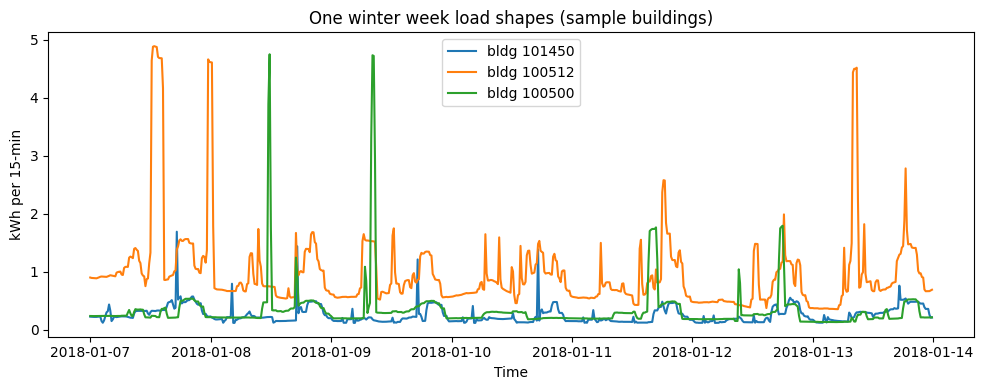

In [9]:
# Convert timestamp and choose 3 buildings
ts_sample["timestamp"] = pd.to_datetime(ts_sample["timestamp"])
bldg_ids_example = ts_sample["bldg_id"].drop_duplicates().sample(
    min(3, ts_sample["bldg_id"].nunique()),
    random_state=0,
).tolist()
print("Example buildings:", bldg_ids_example)

# One winter week
week_mask = (ts_sample["timestamp"] >= "2018-01-07") & (ts_sample["timestamp"] < "2018-01-14")
week_ts = ts_sample[week_mask & ts_sample["bldg_id"].isin(bldg_ids_example)]

plt.figure(figsize=(10, 4))
for b in bldg_ids_example:
    b_ts = week_ts[week_ts["bldg_id"] == b]
    plt.plot(b_ts["timestamp"], b_ts["kwh_total"], label=f"bldg {b}")

plt.xlabel("Time")
plt.ylabel("kWh per 15-min")
plt.title("One winter week load shapes (sample buildings)")
plt.legend()
plt.tight_layout()
plt.show()
